In [1]:
%matplotlib inline
import cPickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

face_cascade = cv2.CascadeClassifier('/home/mckc/Downloads/opencv-2.4.13/data/haarcascades_GPU/haarcascade_frontalface_default.xml')

In [2]:
#Reading the image data into numpy
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:], [0.299, 0.587, 0.114])

def load_data():
    import pandas as pd
    import numpy as np
    from PIL import Image
    
    train = pd.read_csv('/home/mckc/All Data/train.csv')
    test = pd.read_csv('/home/mckc/All Data/test.csv')
    print 'the training data shape is ',train.shape
    print 'the test data shape is ', test.shape
    
    X_tr = np.zeros((1,1944,2592),dtype=np.uint8)
    iteration = 0
    for i in train.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
#     print X_tr.shape,image.shape
        X_tr =  np.vstack((X_tr,image))
        iteration+=1
        if iteration % 50==0:
            print colored((float(iteration)/len(train.values[:,0])*100 ,' Percentage complete'), 'green')
    Y_tr = train.values[:,1]
    X_tr = X_tr[1:,:,:]
    X_ts = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in test.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
        X_ts = np.vstack((X_ts,image))
    Y_ts = test.values[:,1]
    X_ts = X_ts[1:,:,:]
    print 'the training file shape',X_tr.shape,Y_tr.shape
    print 'the testing file shape',X_ts.shape,Y_ts.shape
    
    return X_tr,X_ts,Y_tr,Y_ts    

In [3]:
def simulate(X,Y):
    import scipy as sp
    import scipy.ndimage
    complete = np.zeros((1,96,96),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        complete = np.vstack((complete,X[i,:,:].reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -10,reshape=False,cval=255).reshape(1,96,96)))
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -5,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -10,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -15,reshape=False,cval=255).reshape(1,96,96)))
        complete = np.vstack((complete,rotated.reshape(1,96,96)))
        Y_complete = np.append(Y_complete,([Y[i]]*14))
        if i % 50==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [4]:
def extract_faces(X_tr,Y_tr):
    from cv2 import resize
    import time
    start_time = time.clock()
    all_faces = np.zeros((1,96,96),dtype=np.uint8)
    missing = []
    multiple = []
    Y= []
    for i in range(len(X_tr)):
        faces  = face_cascade.detectMultiScale(X_tr[i,:,:],scaleFactor=1.3,minNeighbors=5,minSize=(70, 70))
        n_faces = len(faces)
        if n_faces is 1:
            for (x,y,w,h) in faces:
                fac = np.array(X_tr[i,:,:])[y:(y+h),x:(x+h)]
                out = (resize(fac,(96,96))).reshape((1,96,96))
                all_faces = np.vstack((all_faces,out))
                Y = np.append(Y,Y_tr[i])
        else:
            if n_faces > 1:
                #print ('There are multiple faces for index %d and with length %d' % (i , n_faces))
                missing = np.append(missing,i)
                #all_faces = np.vstack((all_faces,np.zeros((1,96,96),dtype=np.uint8)))
            else:
                #print ('The face is missing for index %d' %i)
                multiple = np.append(multiple,i)
        if i % 50==0:
            print colored((float(i)/len(X_tr)*100 ,' Percentage complete'), 'green')

    all_faces = all_faces[1:,:,:]
    print all_faces.shape
    print time.clock() - start_time, "seconds"
    return all_faces,missing,multiple,Y

In [5]:
def load(data):
    import os
    import numpy as np
    files = os.listdir('/home/mckc/all_'+data+'/')    
    X = np.zeros((1,96,96),dtype=np.float64)
    Y = []
    iter = 0
    for i in files:
        X = np.vstack((X,np.load('/home/mckc/all_'+data+'/'+i).reshape(1,96,96)))
        index = i.index('_')
        Y = np.append(Y,i[:index])
        iter = iter+1
        if iter % 800 ==0:
            print colored((float(iter)/len(files)*100 ,' Percentage complete'), 'green')
            
    print X[1:,:,:].shape,Y.shape
    return X[1:,:,:],Y

In [6]:
def Save_data(X,Y,data):
    for i in range(len(X)):
        file_name = '/home/mckc/all_'+data+'/'+Y[i]+'_'+str(i)+'.npy'
        np.save(file_name,X[i,:,:])

In [7]:
def Save_Images(X,Y,data):
    import os
    import scipy.misc
    os.chdir('/home/mckc/pycaffe')
    for i in range(len(X)):
        scipy.misc.toimage(X[i,]).save(str(Y[i])+'_'+data+'_'+str(i) +'.jpg')

In [20]:
X_tr,X_tst,Y_tr,Y_tst = load_data()

the training data shape is  (586, 2)
the test data shape is  (195, 2)
(8.532423208191126, ' Percentage complete')
(17.064846416382252, ' Percentage complete')
(25.597269624573375, ' Percentage complete')
(34.129692832764505, ' Percentage complete')
(42.66211604095563, ' Percentage complete')
(51.19453924914675, ' Percentage complete')
(59.72696245733788, ' Percentage complete')
(68.25938566552901, ' Percentage complete')
(76.79180887372013, ' Percentage complete')
(85.32423208191126, ' Percentage complete')
(93.85665529010238, ' Percentage complete')
the training file shape (586, 1944, 2592) (586,)
the testing file shape (195, 1944, 2592) (195,)


In [21]:
X_train,missing,multiple,Y_train = extract_faces(X_tr[:,:,:],Y_tr)
X_test,missing_test,multiple_test,Y_test = extract_faces(X_tst,Y_tst)

(0.0, ' Percentage complete')
(8.532423208191126, ' Percentage complete')
(17.064846416382252, ' Percentage complete')
(25.597269624573375, ' Percentage complete')
(34.129692832764505, ' Percentage complete')
(42.66211604095563, ' Percentage complete')
(51.19453924914675, ' Percentage complete')
(59.72696245733788, ' Percentage complete')
(68.25938566552901, ' Percentage complete')
(76.79180887372013, ' Percentage complete')
(85.32423208191126, ' Percentage complete')
(93.85665529010238, ' Percentage complete')
(498, 96, 96)
135.427813 seconds
(0.0, ' Percentage complete')
(25.64102564102564, ' Percentage complete')
(51.28205128205128, ' Percentage complete')
(76.92307692307693, ' Percentage complete')
(165, 96, 96)
44.682965 seconds


In [22]:
import time
start_time = time.clock()
X,Y = simulate(X_train,Y_train)
print X.shape,Y.shape
print time.clock() - start_time, "seconds"

(0.0, ' Percentage complete')
(10.040160642570282, ' Percentage complete')
(20.080321285140563, ' Percentage complete')
(30.120481927710845, ' Percentage complete')
(40.16064257028113, ' Percentage complete')
(50.20080321285141, ' Percentage complete')
(60.24096385542169, ' Percentage complete')
(70.28112449799197, ' Percentage complete')
(80.32128514056225, ' Percentage complete')
(90.36144578313254, ' Percentage complete')
(6972, 96, 96) (6972,)
34.600562 seconds


In [23]:
Save_data(X,Y,'train')
Save_data(X_test,Y_test,'test')

In [24]:
X.shape,Y.shape

((6972, 96, 96), (6972,))

In [8]:
X,Y = load('train')
X_test,Y_test = load('test')

(11.474469305794607, ' Percentage complete')
(22.948938611589213, ' Percentage complete')
(34.42340791738382, ' Percentage complete')
(45.897877223178426, ' Percentage complete')
(57.37234652897304, ' Percentage complete')
(68.84681583476764, ' Percentage complete')
(80.32128514056225, ' Percentage complete')
(91.79575444635685, ' Percentage complete')
(6972, 96, 96) (6972,)
(165, 96, 96) (165,)


def standard(X):
    return (X - X.mean())

X_test = standard(X_test)
X = standard(X)

In [9]:
X_normal = X.reshape(-1,9216)
X_test_normal = X_test.reshape(-1,9216)
map, Y_number = np.unique(Y, return_inverse=True)
Y_test_number = np.unique(Y_test, return_inverse=True)[1]

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = LogisticRegression(verbose=0,n_jobs=-1,multi_class='multinomial',solver='lbfgs',max_iter=100,warm_start=True)
#scores = cross_validation.cross_val_score(clf, X_normal, Y_number, cv=5)
#print scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [56]:
clf.fit(X_normal,Y_number)
Y_logictic= clf.predict(X_test.reshape(-1,9216))
Y_log_vales = map[Y_logictic]

print 'Accuracy of the model is ',accuracy_score(Y_test,Y_log_vales)
confusion_matrix(Y_log_vales,Y_test)

Accuracy of the model is  0.945454545455


array([[17,  0,  0,  0,  0,  0,  0],
       [ 1, 19,  0,  0,  0,  0,  2],
       [ 0,  0, 25,  0,  0,  0,  2],
       [ 0,  0,  0, 23,  0,  0,  1],
       [ 0,  0,  0,  0, 26,  0,  2],
       [ 0,  0,  0,  0,  0, 17,  0],
       [ 0,  0,  0,  0,  0,  1, 29]])

In [57]:
clf.coef_.shape

(7, 9216)

Abhay


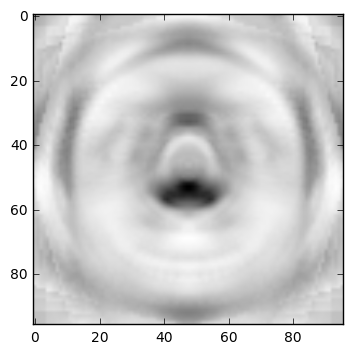

In [58]:
print map[0]
plt.imshow(clf.coef_[0,:].reshape(96,96),cmap=cm.Greys_r)

Arun


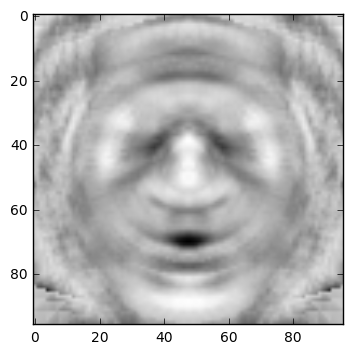

In [59]:
print map[1]
plt.imshow(clf.coef_[1,:].reshape(96,96),cmap=cm.Greys_r)

Gopika


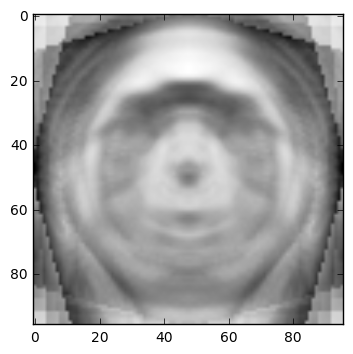

In [60]:
print map[2]
plt.imshow(clf.coef_[2,:].reshape(96,96),cmap=cm.Greys_r)

Kinkar


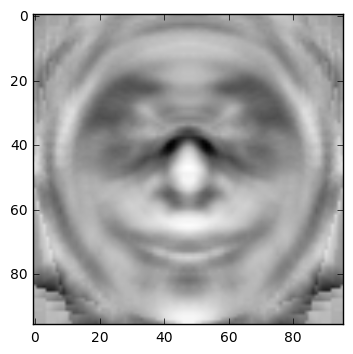

In [61]:
print map[3]
plt.imshow(clf.coef_[3,:].reshape(96,96),cmap=cm.Greys_r)

Omar


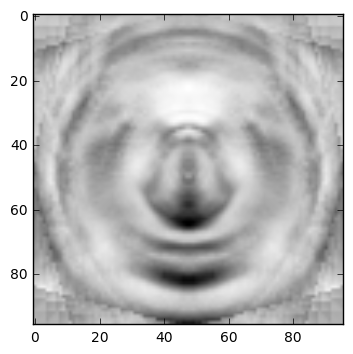

In [62]:
print map[4]
plt.imshow(clf.coef_[4,:].reshape(96,96),cmap=cm.Greys_r)

Pandian


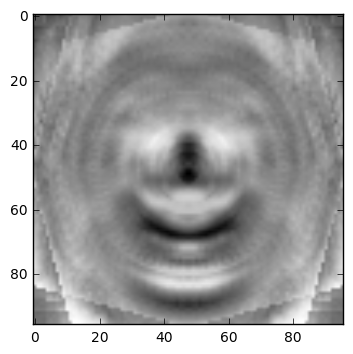

In [63]:
print map[5]
plt.imshow(clf.coef_[5,:].reshape(96,96),cmap=cm.Greys_r)

Sharath


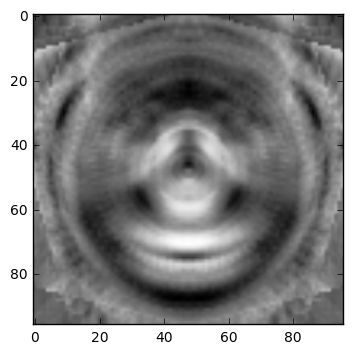

In [64]:
print map[6]
plt.imshow(clf.coef_[6,:].reshape(96,96),cmap=cm.Greys_r)

In [65]:
from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(200,verbose=0,oob_score=True,n_jobs=-1,warm_start=True)
#scores = cross_validation.cross_val_score(recognizer, X_normal, Y_number, cv=5)
#print scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [66]:
recognizer.fit(X_normal,Y_number)

Y_rf= recognizer.predict(X_test.reshape(-1,9216))
Y_rf_vales = map[Y_rf]

print 'Accuracy of the model is ',accuracy_score(Y_test,Y_rf_vales)
confusion_matrix(Y_test,Y_rf_vales)

Accuracy of the model is  0.781818181818


array([[ 4,  7,  0,  0,  7,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  0],
       [ 0,  0, 25,  0,  0,  0,  0],
       [ 0,  2,  0, 21,  0,  0,  0],
       [ 0,  0,  0,  0, 25,  0,  1],
       [ 0, 10,  0,  0,  0,  8,  0],
       [ 0,  8,  0,  0,  0,  1, 27]])

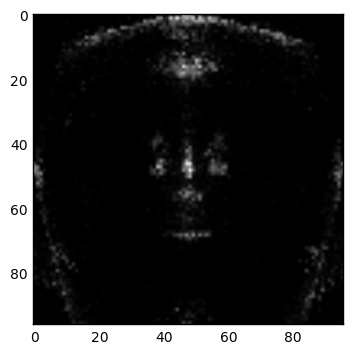

In [67]:
importances = recognizer.feature_importances_
importance_image = importances.reshape(96,96)
#plt.figure(figsize=(7,7))
plt.imshow(importance_image,cmap=cm.Greys_r)

In [68]:
import lasagne
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne import layers
from lasagne.objectives import categorical_crossentropy
from lasagne.updates import nesterov_momentum,adadelta
from nolearn.lasagne import BatchIterator,visualize,NeuralNet
Conv2DLayer = layers.Conv2DLayer
MaxPool2DLayer = layers.MaxPool2DLayer

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=7,
    
    update = adadelta,
    update_learning_rate=0.1,
#    update_momentum=0.9,
    max_epochs=15,
    verbose=1
)

In [69]:
net.fit(X.reshape(-1,1,96,96).astype(np.float32), Y_number.astype(np.uint8))

# Neural Network with 16538479 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    7

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     7.68604     0.77465    9.92197      0.81044  7.81s
      2     0.83509     0.33041    2.52743      0.95136  7.95s
      3     0.45704     0.16780    2.72370      0.96567  7.93s
      4     0.32537     0.09845    3.30483      0.97568  7.93s
      5     0.16746     0.05010    3.34271      0.99499  7.90s
      6     0.14206     0.02709    5.24425      0.99571  7.92s
      7     0.07620     0.03009    2.53226      0.99285  7

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f79c889c090>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f79c888df10>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,AveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam,SGD,Adadelta,Adagrad
from keras import backend as K

Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)

model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',input_shape=( 1, 96, 96),activation='relu'))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(96, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(192, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(256, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(160, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(320, 3, 3,border_mode='same',activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Flatten())
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dense(7,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
#model.load_weights("model.h5")

In [73]:
model.fit(X.reshape(-1,1,96,96), Y_Keras, nb_epoch=20, batch_size=20,verbose=1,shuffle=True,
          validation_data=(X_test.reshape(-1,1,96,96),Y_Keras_test))

Train on 6972 samples, validate on 165 samples
Epoch 1/20
6972/6972 [==============================] - 107s - loss: 0.6502 - acc: 0.7577 - val_loss: 0.2317 - val_acc: 0.8970
Epoch 2/20
6972/6972 [==============================] - 109s - loss: 0.0355 - acc: 0.9918 - val_loss: 0.1039 - val_acc: 0.9455
Epoch 3/20
6972/6972 [==============================] - 108s - loss: 0.0206 - acc: 0.9943 - val_loss: 0.2167 - val_acc: 0.9333
Epoch 4/20
6972/6972 [==============================] - 109s - loss: 0.0173 - acc: 0.9947 - val_loss: 0.0727 - val_acc: 0.9758
Epoch 5/20
6972/6972 [==============================] - 105s - loss: 0.0110 - acc: 0.9960 - val_loss: 1.1603 - val_acc: 0.7939
Epoch 6/20
6972/6972 [==============================] - 109s - loss: 0.0103 - acc: 0.9970 - val_loss: 0.3241 - val_acc: 0.9030
Epoch 7/20
6972/6972 [==============================] - 108s - loss: 0.0217 - acc: 0.9934 - val_loss: 0.1728 - val_acc: 0.9394
Epoch 8/20
6972/6972 [==============================] - 106s - l

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD,Adadelta,Adagrad
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=9216,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dense(7,activation='softmax'))
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adagrad = Adagrad(lr=0.001, epsilon=1e-08)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['accuracy'])

model.fit(X.reshape(-1,9216), Y_Keras, nb_epoch=4, batch_size=20,verbose=1,shuffle=True,
          validation_data=(X_test.reshape(-1,9216),Y_Keras_test))

Train on 6972 samples, validate on 165 samples
Epoch 1/4
6972/6972 [==============================] - 4s - loss: 0.4025 - acc: 0.8755 - val_loss: 0.1822 - val_acc: 0.9758
Epoch 2/4
6972/6972 [==============================] - 5s - loss: 0.0811 - acc: 0.9838 - val_loss: 0.0718 - val_acc: 0.9818
Epoch 3/4
6972/6972 [==============================] - 4s - loss: 0.0436 - acc: 0.9904 - val_loss: 0.0393 - val_acc: 0.9818
Epoch 4/4
6972/6972 [==============================] - 4s - loss: 0.0331 - acc: 0.9937 - val_loss: 0.0593 - val_acc: 0.9818


In [47]:
import cPickle
# save the classifier
with open('/home/mckc/nolearn_model.pkl', 'wb') as fid:
    cPickle.dump(net, fid)    

np.save('/home/mckc/map',map)

RuntimeError: maximum recursion depth exceeded while calling a Python object

In [48]:
with open('/home/mckc/random_model.pkl', 'wb') as fid:
    cPickle.dump(recognizer, fid)  

In [49]:
with open('/home/mckc/linear_model.pkl', 'wb') as fid:
    cPickle.dump(clf, fid)  

In [23]:
Save_Images(X,Y,'train')
Save_Images(X_test,Y_test,'test')

In [18]:
print X_test.shape,Y_test.shape

(165, 96, 96) (165,)


In [51]:
from keras.models import model_from_json,model_from_yaml
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

from keras.models import model_from_json,model_from_yaml
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Saved model to disk


In [52]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk


In [13]:
import lmdb
import os
os.chdir('/home/mckc/pycaffe')
import caffe

In [14]:

map_size = X.nbytes * 10

N = X.shape[0]

env = lmdb.open('train_lmdb', map_size=map_size)

with env.begin(write=True) as txn:
    # txn is a Transaction object
    for i in range(N):
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = 1
        datum.height = X.shape[1]
        datum.width = X.shape[2]
        datum.data = X[i].tobytes()  # or .tostring() if numpy < 1.9
        datum.label = int(Y_number[i])
        str_id = '{:08}'.format(i)

        # The encode is only essential in Python 3
        #txn.put(str_id.encode('ascii'), datum.SerializeToString())
        
N = X_test.shape[0]
env = lmdb.open('test_lmdb', map_size=map_size)

with env.begin(write=True) as txn:
    # txn is a Transaction object
    for i in range(N):
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = 1
        datum.height = X.shape[1]
        datum.width = X.shape[2]
        datum.data = X_test[i].tobytes()  # or .tostring() if numpy < 1.9
        datum.label = int(Y_test_number[i])
        str_id = '{:08}'.format(i)

        # The encode is only essential in Python 3
        #txn.put(str_id.encode('ascii'), datum.SerializeToString())


NameError: name 'X' is not defined

In [15]:
import caffe 
from caffe import layers as L, params as P

def lenet(data_location, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    #n.data, n.label  = L.MemoryData(batch_size = batch_size, height = 96, width = 96, channels = 1,ntop=2)
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=data_location, ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=32,  pad=1,weight_filler=dict(type='xavier'))
    n.conv2 = L.Convolution(n.conv1, kernel_size=3, num_output=64,  pad=1,weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv21 = L.Convolution(n.pool1, kernel_size=3, num_output=64, pad=1,weight_filler=dict(type='xavier'))
    n.conv22 = L.Convolution(n.conv21, kernel_size=3, num_output=128, pad=1,weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv22, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv31 = L.Convolution(n.pool2, kernel_size=3, num_output=96,pad=1, weight_filler=dict(type='xavier'))
    n.conv32 = L.Convolution(n.conv31, kernel_size=3, num_output=192,pad=1, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv32, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv41 = L.Convolution(n.pool3, kernel_size=3, num_output=128, pad=1,weight_filler=dict(type='xavier'))
    n.conv42 = L.Convolution(n.conv41, kernel_size=3, num_output=256, pad=1,weight_filler=dict(type='xavier'))
    n.pool4 = L.Pooling(n.conv42, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv51 = L.Convolution(n.pool4, kernel_size=3, num_output=64, pad=1,weight_filler=dict(type='xavier'))
    n.conv52 = L.Convolution(n.conv51, kernel_size=3, num_output=128,pad=1, weight_filler=dict(type='xavier'))
    n.pool5 = L.Pooling(n.conv52, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    n.fc1 =   L.InnerProduct(n.pool5, num_output=1000, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=7, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('train.prototxt', 'w') as f:
    f.write(str(lenet('/home/mckc/pycaffe/train_lmdb/', 1)))
    
with open('test.prototxt', 'w') as f:
    f.write(str(lenet('/home/mckc/pycaffe/test_lmdb/', 1)))

In [16]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path):
    s = caffe_pb2.SolverParameter()
    s.train_net = 'train.prototxt'
    s.test_net.append('test.prototxt')

    s.test_interval = 1000  # Test after every 1000 training iterations.
    s.test_iter.append(250) # Test 250 "batches" each time we test.

    s.max_iter = 10000      # # of times to update the net (training iterations)

    # Set the initial learning rate for stochastic gradient descent (SGD).
    s.base_lr = 0.1        

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.01
    s.stepsize = 5000

    # Set other optimization parameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- just once at the end of training.
    # For larger networks that take longer to train, you may want to set
    # snapshot < max_iter to save the network and training state to disk during
    # optimization, preventing disaster in case of machine crashes, etc.
    s.snapshot = 10000
    s.snapshot_prefix = '/summary'

    # We'll train on the CPU for fair benchmarking against scikit-learn.
    # Changing to GPU should result in much faster training!
    #s.solver_mode = caffe_pb2.SolverParameter.CPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s

solver_path = 'solver.prototxt'
with open(solver_path, 'w') as f:
    f.write(str(solver('train.prototxt', 'test.prototxt')))

In [17]:
caffe.set_device(0)
caffe.set_mode_gpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
#solver = caffe.SGDSolver('/home/mckc/pycaffe/lenet_auto_solver.prototxt')
solver = caffe.SGDSolver('solver.prototxt')

In [ ]:
net = caffe.Net('solver.prototxt', caffe.TEST)

In [5]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 1, 96, 96)),
 ('label', (1,)),
 ('conv1', (1, 32, 96, 96)),
 ('conv2', (1, 64, 96, 96)),
 ('pool1', (1, 64, 48, 48)),
 ('conv21', (1, 64, 48, 48)),
 ('conv22', (1, 128, 48, 48)),
 ('pool2', (1, 128, 24, 24)),
 ('conv31', (1, 96, 24, 24)),
 ('conv32', (1, 192, 24, 24)),
 ('pool3', (1, 192, 12, 12)),
 ('conv41', (1, 128, 12, 12)),
 ('conv42', (1, 256, 12, 12)),
 ('pool4', (1, 256, 6, 6)),
 ('conv51', (1, 64, 6, 6)),
 ('conv52', (1, 128, 6, 6)),
 ('pool5', (1, 128, 3, 3)),
 ('fc1', (1, 1000)),
 ('score', (1, 7)),
 ('loss', ())]

In [9]:
solver.step(1)
print solver.net.forward()['loss'] # train net
print solver.test_nets[0].forward()['loss']  # test net (there can be more than one)

87.3365478516
87.3365478516


In [7]:
solver.solve()

In [12]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(87.3365478515625, dtype=float32)}

In [11]:
solver.net.save('model.caffemodel')

In [ ]:
caffe.set_mode_cpu()

model_def = '/home/mckc/pycaffe/solver.prototxt'
model_weights = '/home/mckc/pycaffe/model.caffemodel'

pre_trained = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [28]:
import numpy as np
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    #output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        print 'test loss',solver.test_nets[0].forward()['loss']
        for test_it in range(100):
            solver.test_nets[0].forward()['loss']
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
test loss 87.3365478516
Iteration 25 testing...
test loss 87.3365478516
Iteration 50 testing...
test loss 87.3365478516
Iteration 75 testing...
test loss 87.3365478516
Iteration 100 testing...
test loss 87.3365478516
Iteration 125 testing...
test loss 87.3365478516
Iteration 150 testing...
test loss 87.3365478516
Iteration 175 testing...
test loss 87.3365478516


Iteration 0 testing...


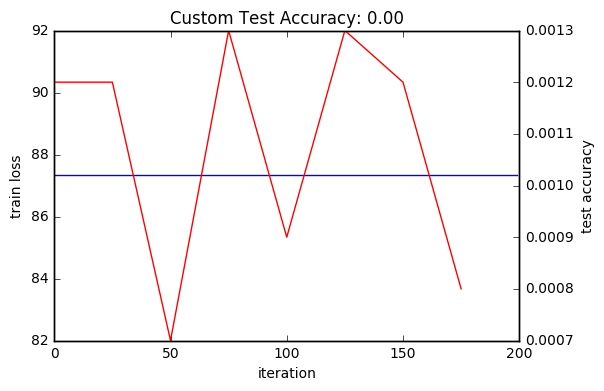

In [29]:
from pylab import *
%matplotlib inline
# the main solver loop
for it in range(10):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

In [49]:
solver.net.set_input_arrays(X.reshape(-1,1,96,96).astype(np.float32),Y_number.astype(np.float32))
data4D = np.ones([1,CHANNEL,HEIGHT,WIDTH])
data4DL = np.zeros([1,14,1,1])
pred_normal = np.zeros([NUMBER,14])
n = 0
for n in range(0, NUMBER):
    data4D[0] = X_test[n]
    data4DL[0][0][0][0] = n
    net.set_input_arrays(\
      data4D.astype(np.float32), data4DL.astype(np.float32))
    pred = net.forward()
    for c in range(0,14):
        pred_normal[n][c] = pred['loss'][0][c][0][0]

RuntimeError: set_input_arrays may only be called if the first layer is a MemoryDataLayer